In [254]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.express as px
import sklearn
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,precision_score,recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,roc_auc_score
import warnings 
warnings.filterwarnings('ignore')

In [255]:
df = pd.read_csv('churn_clean.csv',dtype={'locationid':np.int64}) 

df.head(5)

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,MonthlyCharge,Bandwidth_GB_Year,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,e885b299883d4f9fb18e39c75155d990,Point Baker,AK,Prince of Wales-Hyder,99927,56.25100,-133.37571,...,172.455519,904.536110,5,5,5,3,4,4,3,4
1,2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,f2de8bef964785f41a2959829830fb8a,West Branch,MI,Ogemaw,48661,44.32893,-84.24080,...,242.632554,800.982766,3,4,3,3,4,3,4,4
2,3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,f1784cfa9f6d92ae816197eb175d3c71,Yamhill,OR,Yamhill,97148,45.35589,-123.24657,...,159.947583,2054.706961,4,4,2,4,4,3,3,3
3,4,D90850,abfa2b40-2d43-4994-b15a-989b8c79e311,dc8a365077241bb5cd5ccd305136b05e,Del Mar,CA,San Diego,92014,32.96687,-117.24798,...,119.956840,2164.579412,4,4,4,2,5,4,3,3
4,5,K662701,68a861fd-0d20-4e51-a587-8a90407ee574,aabb64a116e83fdc4befc1fbab1663f9,Needville,TX,Fort Bend,77461,29.38012,-95.80673,...,149.948316,271.493436,4,4,4,3,4,4,4,5


In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CaseOrder             10000 non-null  int64  
 1   Customer_id           10000 non-null  object 
 2   Interaction           10000 non-null  object 
 3   UID                   10000 non-null  object 
 4   City                  10000 non-null  object 
 5   State                 10000 non-null  object 
 6   County                10000 non-null  object 
 7   Zip                   10000 non-null  int64  
 8   Lat                   10000 non-null  float64
 9   Lng                   10000 non-null  float64
 10  Population            10000 non-null  int64  
 11  Area                  10000 non-null  object 
 12  TimeZone              10000 non-null  object 
 13  Job                   10000 non-null  object 
 14  Children              10000 non-null  int64  
 15  Age                 

### Data Cleaning

In [257]:
print(df.duplicated().value_counts())

False    10000
dtype: int64


In [258]:
df.isnull().sum()

CaseOrder               0
Customer_id             0
Interaction             0
UID                     0
City                    0
State                   0
County                  0
Zip                     0
Lat                     0
Lng                     0
Population              0
Area                    0
TimeZone                0
Job                     0
Children                0
Age                     0
Income                  0
Marital                 0
Gender                  0
Churn                   0
Outage_sec_perweek      0
Email                   0
Contacts                0
Yearly_equip_failure    0
Techie                  0
Contract                0
Port_modem              0
Tablet                  0
InternetService         0
Phone                   0
Multiple                0
OnlineSecurity          0
OnlineBackup            0
DeviceProtection        0
TechSupport             0
StreamingTV             0
StreamingMovies         0
PaperlessBilling        0
PaymentMetho

In [259]:
CheckOutliers = ['Children', 'Age', 'Income', 'Outage_sec_perweek','Email', 'Contacts', 'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']
CheckOutliers

['Children',
 'Age',
 'Income',
 'Outage_sec_perweek',
 'Email',
 'Contacts',
 'Yearly_equip_failure',
 'Tenure',
 'MonthlyCharge',
 'Bandwidth_GB_Year']

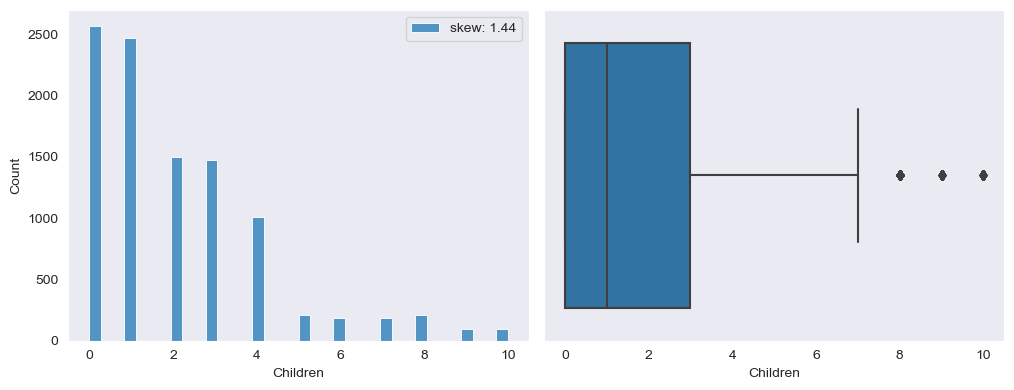

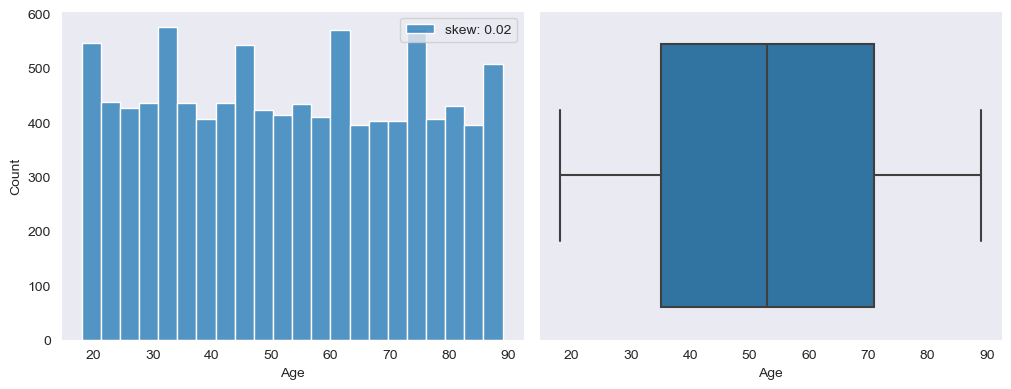

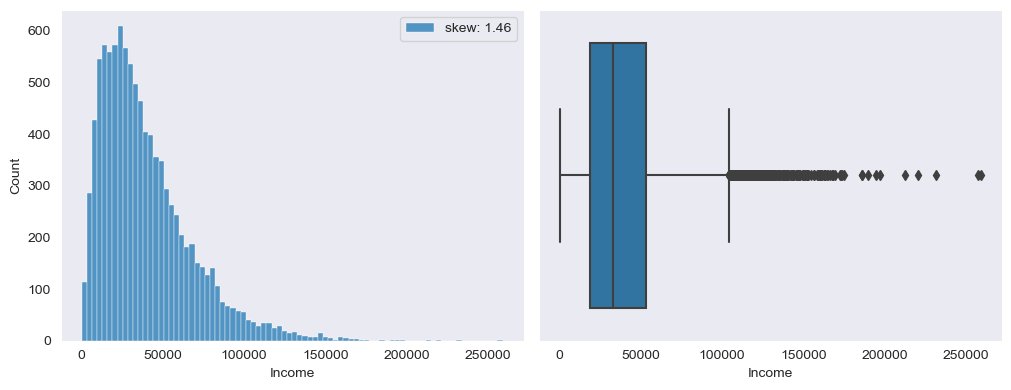

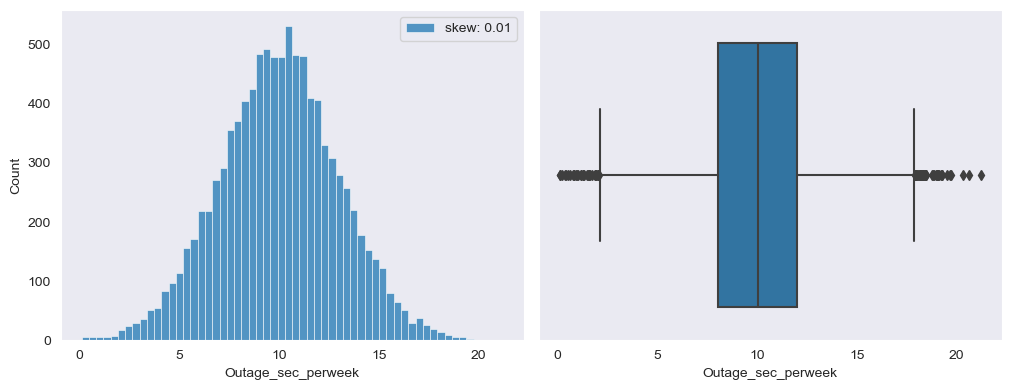

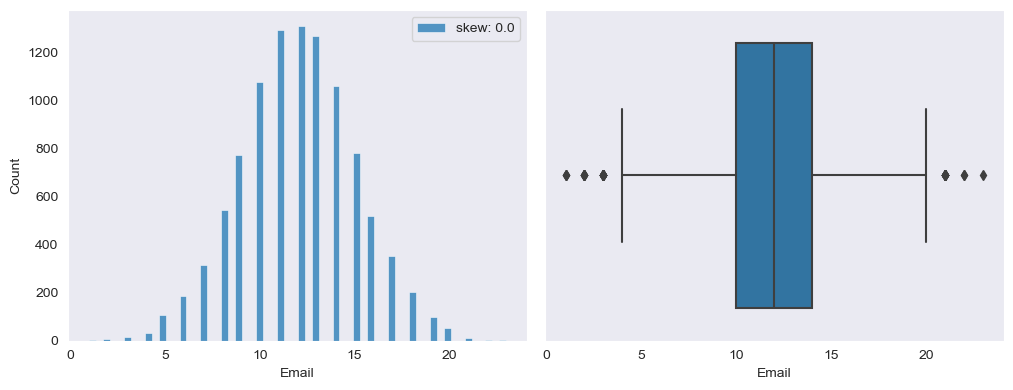

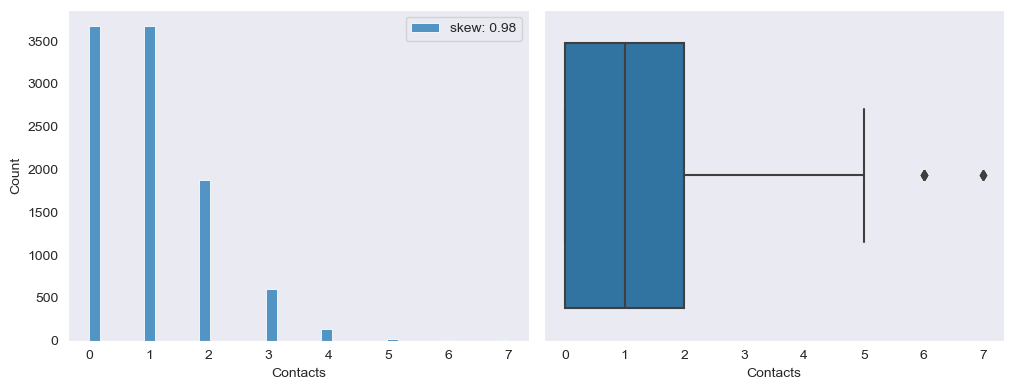

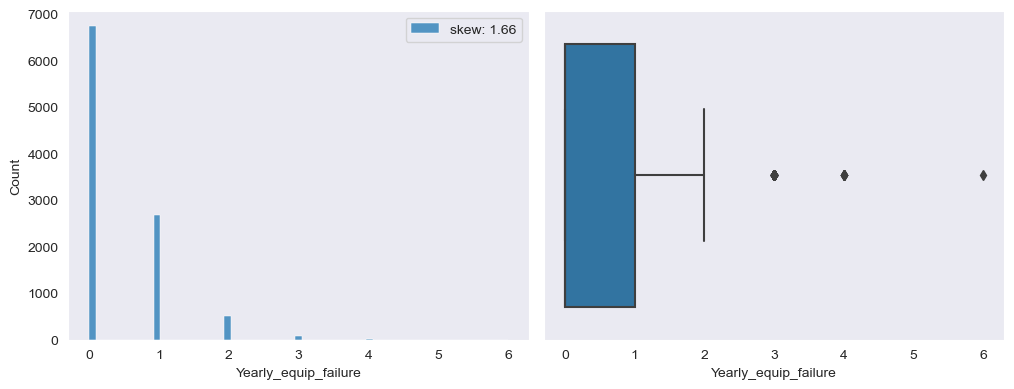

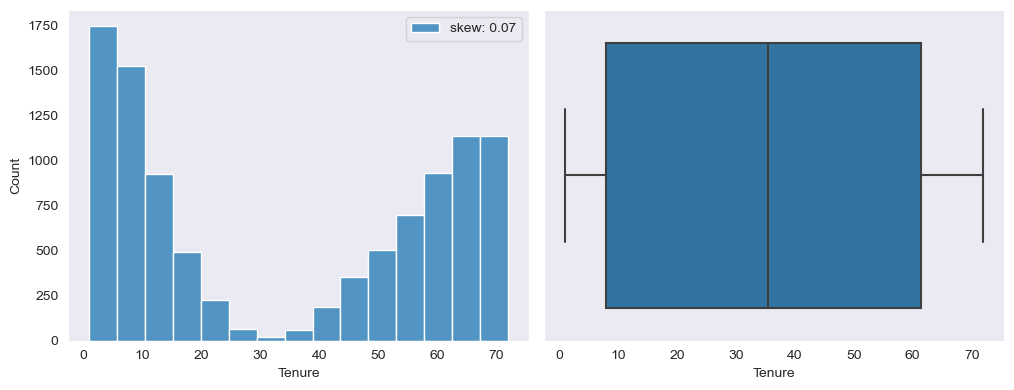

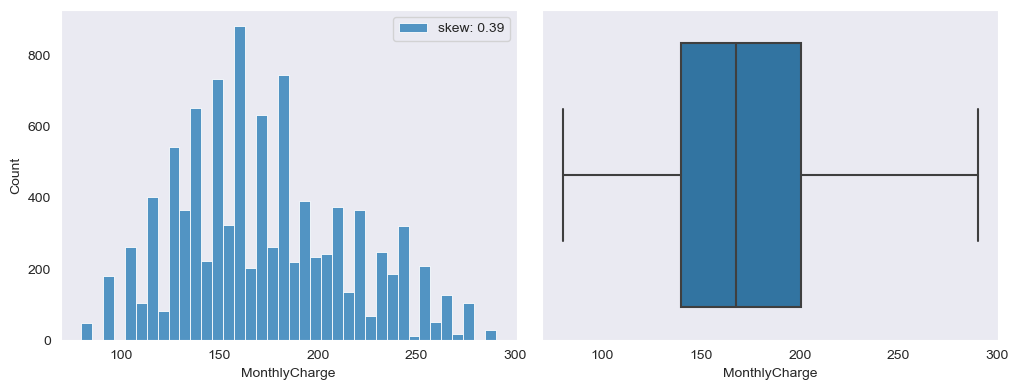

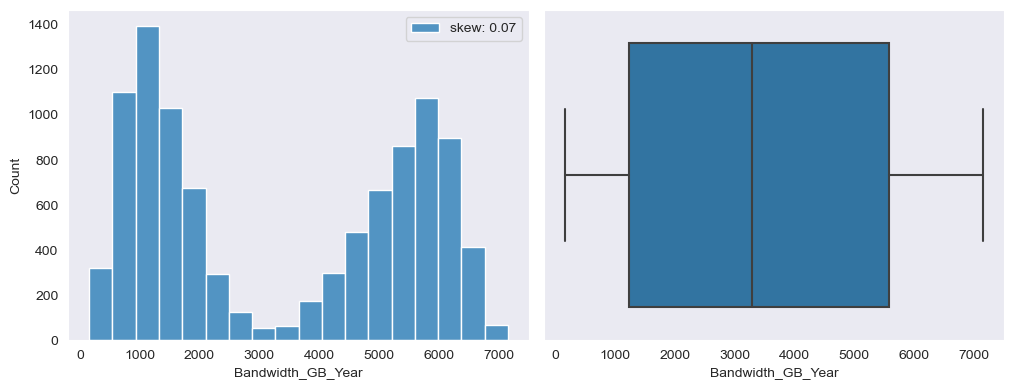

In [260]:
sns.set_style('dark')
for col in CheckOutliers:
    plt.figure(figsize=(15,4))
    plt.subplot(131)
    sns.histplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))
    plt.legend()
    plt.subplot(132)
    sns.boxplot(df[col])
    plt.tight_layout()
    plt.show()

In [261]:
outliers_new = ['Children', 'Income', 'Outage_sec_perweek','Email', 'Contacts', 'Yearly_equip_failure']
outliers_new 

['Children',
 'Income',
 'Outage_sec_perweek',
 'Email',
 'Contacts',
 'Yearly_equip_failure']

In [262]:
df_cop = df.copy()

In [263]:
def iqr_capping(df, cols, factor):
    
    for col in cols:
        
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        
        iqr = q3 - q1
        
        upper_whisker = q3 + (factor*iqr)
        lower_whisker = q1 - (factor*iqr)
        
        df[col] = np.where(df[col]>upper_whisker, upper_whisker,
                  np.where(df[col]<lower_whisker, lower_whisker, df[col]))

In [264]:
iqr_capping(df_cop, outliers_new, 1.5)

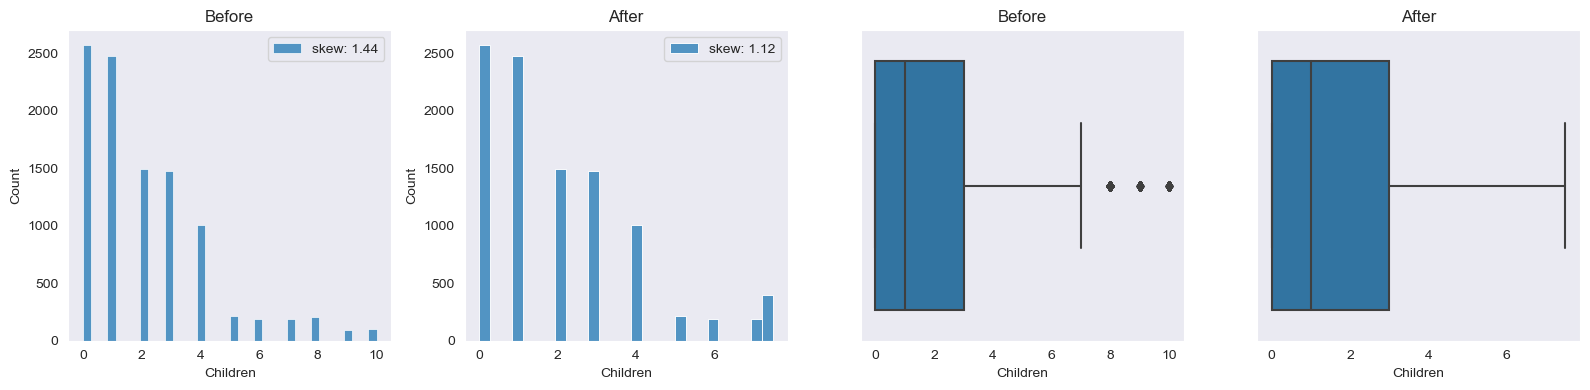

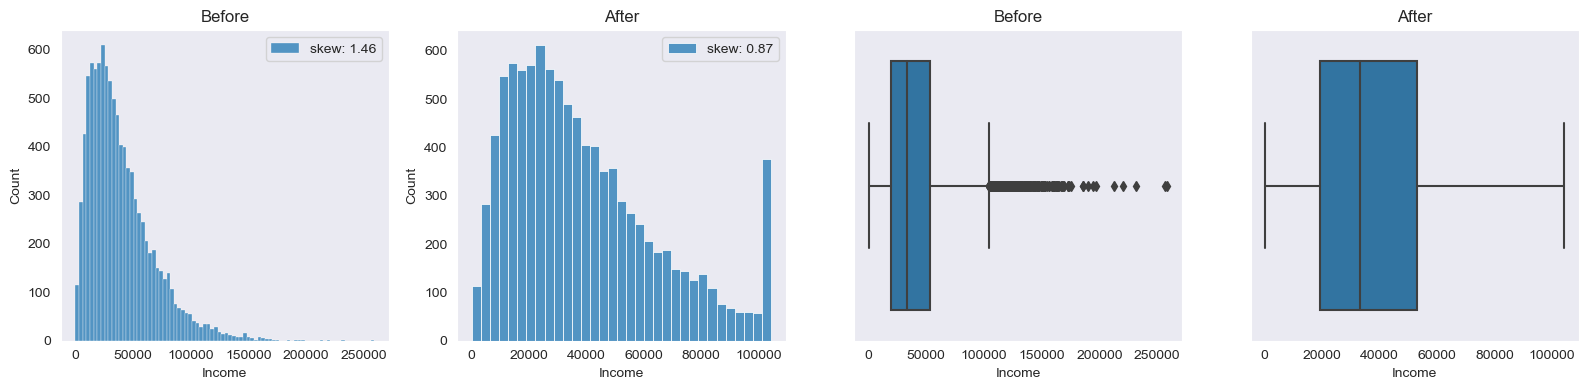

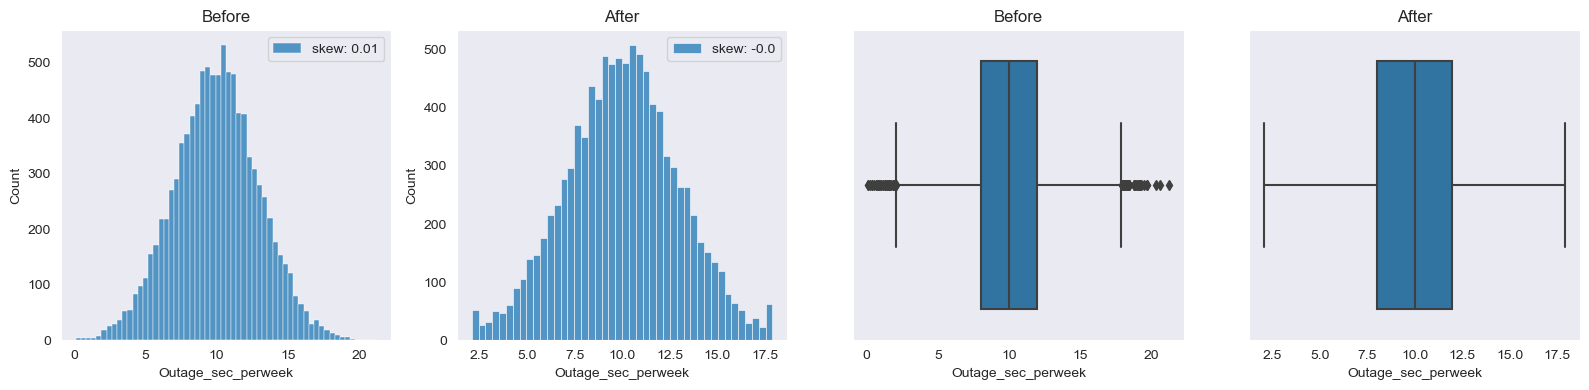

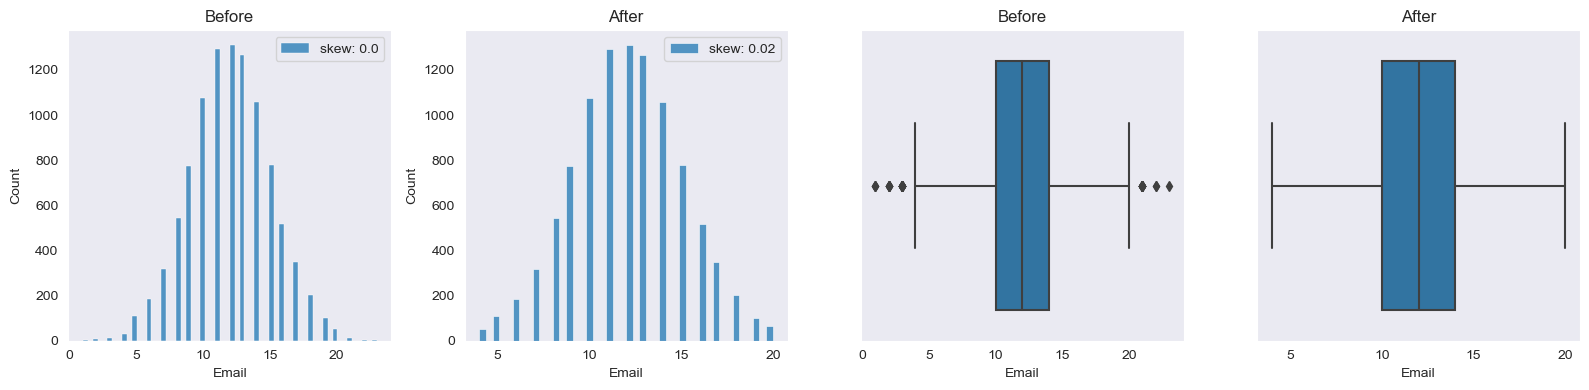

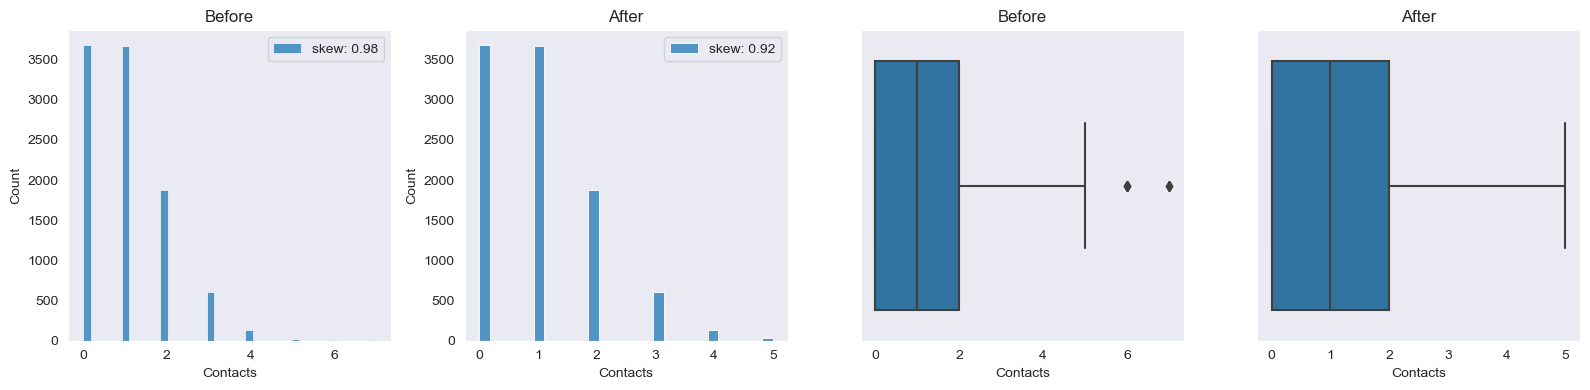

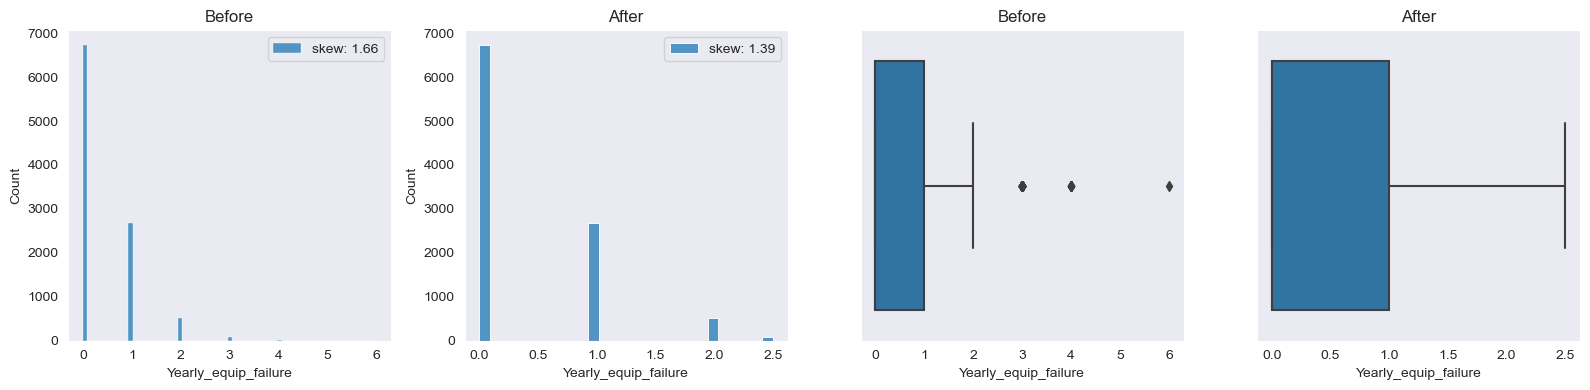

In [265]:
for col in outliers_new:
    plt.figure(figsize=(16,4))
    
    plt.subplot(141)
    sns.histplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))
    plt.title('Before')
    plt.legend()
    
    plt.subplot(142)
    sns.histplot(df_cop[col], label="skew: " + str(np.round(df_cop[col].skew(),2)))
    plt.title('After')
    plt.legend()
    
    plt.subplot(143)
    sns.boxplot(df[col])
    plt.title('Before')
    
    plt.subplot(144)
    sns.boxplot(df_cop[col])
    plt.title('After')
    plt.tight_layout()
    plt.show()

### Data Exploration - Univariate

In [266]:
df[['Children', 'Age', 'Income', 'Outage_sec_perweek','Email', 'Contacts', 'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']].describe()

,Children,Age,Income,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year
count,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.0877,53.078400,39806.926771,10.001848,12.016000,0.994200,0.398000,34.526188,172.624816,3392.341550
std,2.1472,20.698882,28199.916702,2.976019,3.025898,0.988466,0.635953,26.443063,42.943094,2185.294852
min,0.0000,18.000000,348.670000,0.099747,1.000000,0.000000,0.000000,1.000259,79.978860,155.506715
25%,0.0000,35.000000,19224.717500,8.018214,10.000000,0.000000,0.000000,7.917694,139.979239,1236.470827
50%,1.0000,53.000000,33170.605000,10.018560,12.000000,1.000000,0.000000,35.430507,167.484700,3279.536903
75%,3.0000,71.000000,53246.170000,11.969485,14.000000,2.000000,1.000000,61.479795,200.734725,5586.141370
max,10.0000,89.000000,258900.700000,21.207230,23.000000,7.000000,6.000000,71.999280,290.160419,7158.981530


In [267]:
df[['Techie', 'Churn', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'OnlineBackup', 'OnlineSecurity', 'Port_modem', 'Multiple', 'DeviceProtection']].value_counts()

Techie  Churn  StreamingMovies  StreamingTV  TechSupport  OnlineBackup  OnlineSecurity  Port_modem  Multiple  DeviceProtection
No      No     No               No           No           No            No              Yes         No        No                  80
                                                                                        No          No        No                  72
                                Yes          No           No            No              Yes         No        No                  69
                                                                                        No          Yes       No                  67
                                No           No           Yes           No              Yes         No        No                  66
                                                                                                                                  ..
Yes     No     Yes              No           Yes          Yes           No 

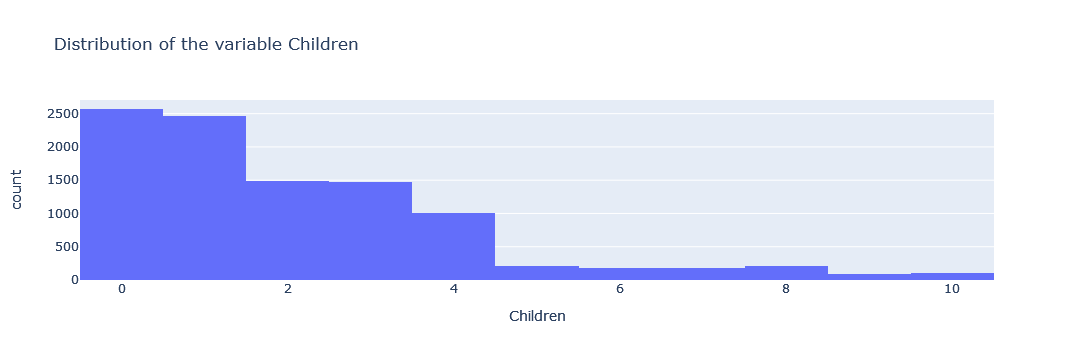

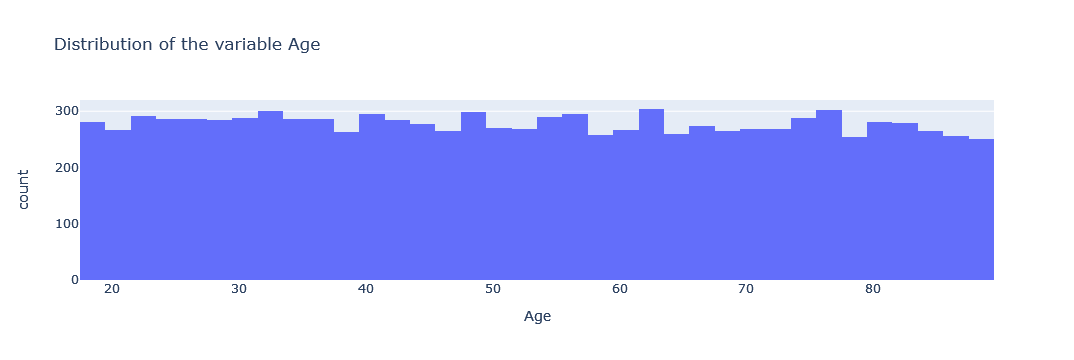

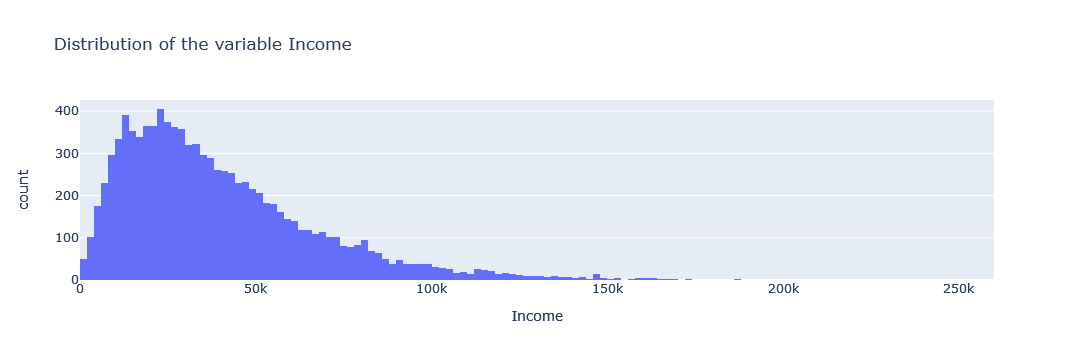

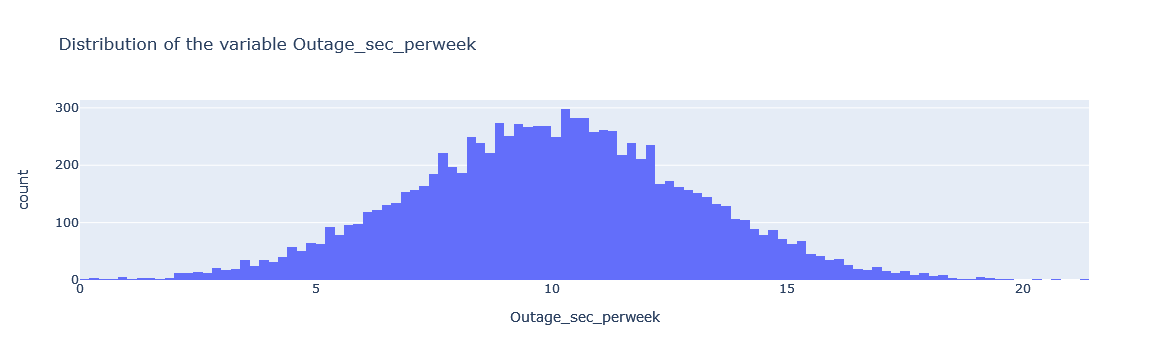

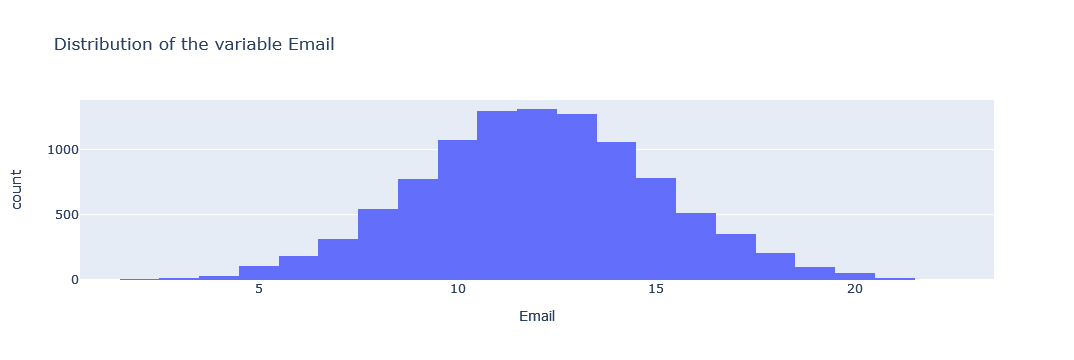

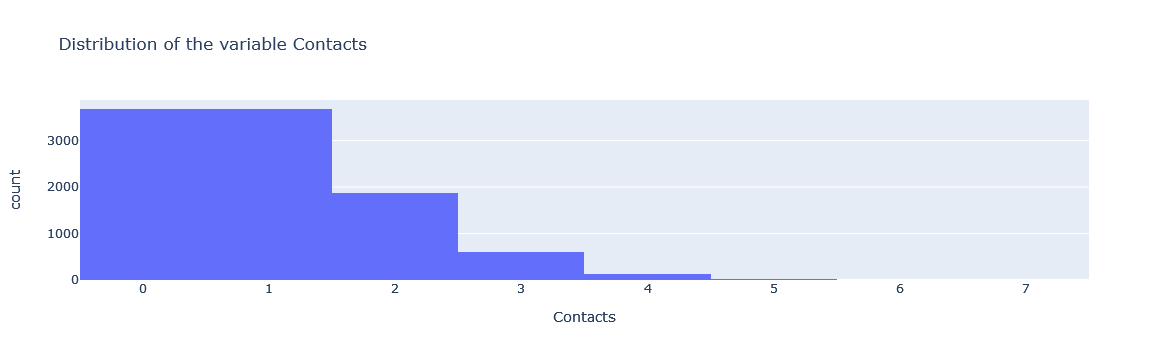

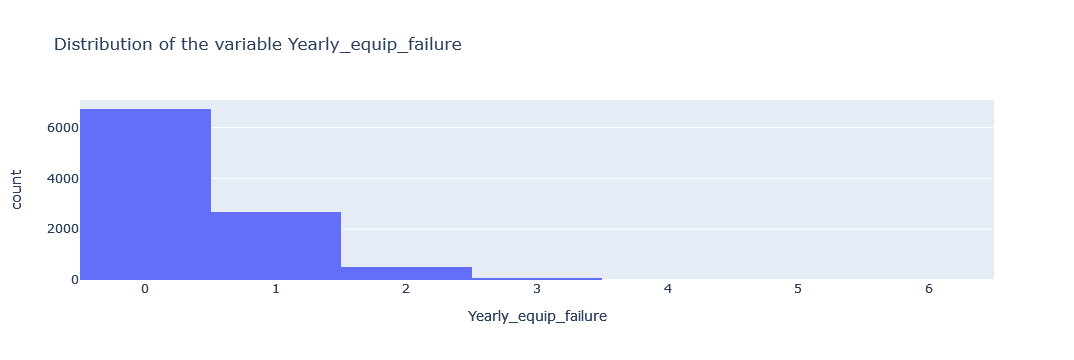

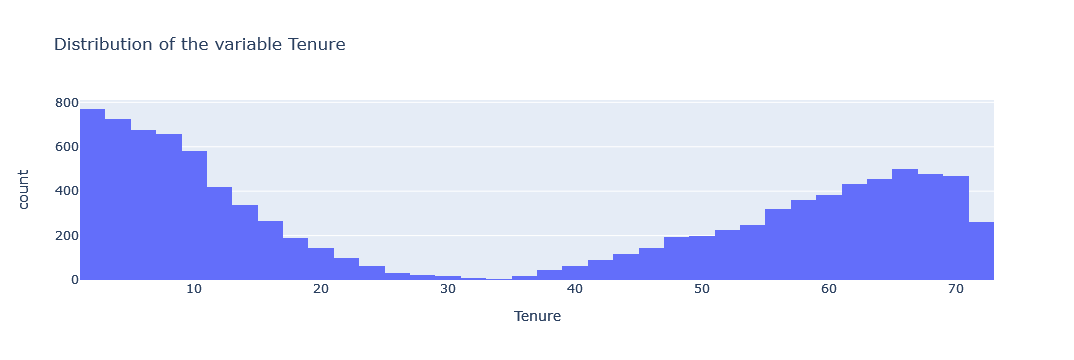

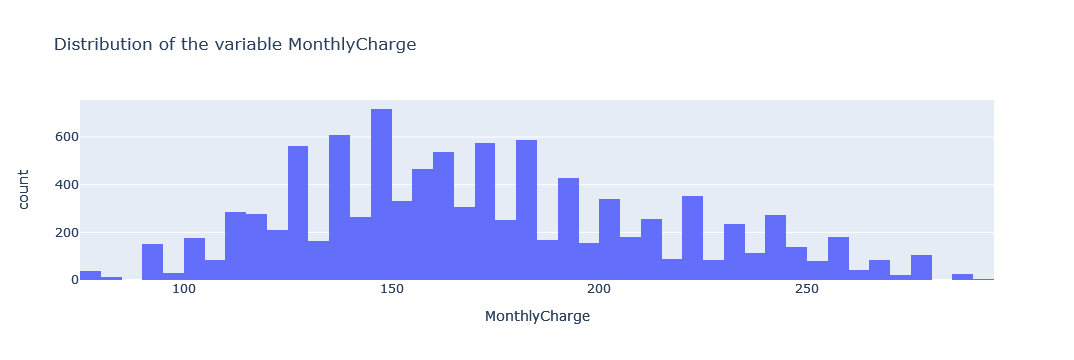

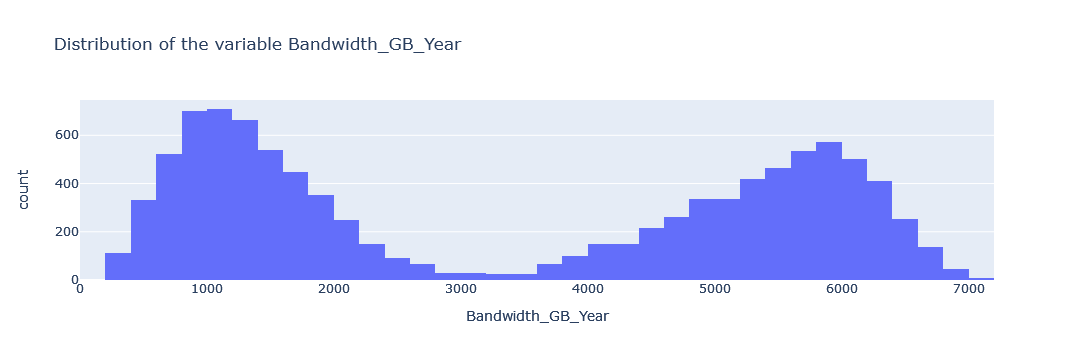

In [268]:
for i in CheckOutliers:
    fig = px.histogram(df, x=i, title=f"Distribution of the variable {i}")
    fig.update_layout( xaxis={'categoryorder':'total descending'})
    fig.show()

In [269]:
categorical= ['Techie', 'Churn', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'OnlineBackup', 'OnlineSecurity', 'Port_modem', 'Multiple', 'DeviceProtection']
categorical

['Techie',
 'Churn',
 'StreamingMovies',
 'StreamingTV',
 'TechSupport',
 'OnlineBackup',
 'OnlineSecurity',
 'Port_modem',
 'Multiple',
 'DeviceProtection']

In [270]:
df_categorical= df[['Techie', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'OnlineBackup', 'OnlineSecurity', 'Port_modem', 'Multiple', 'DeviceProtection']]

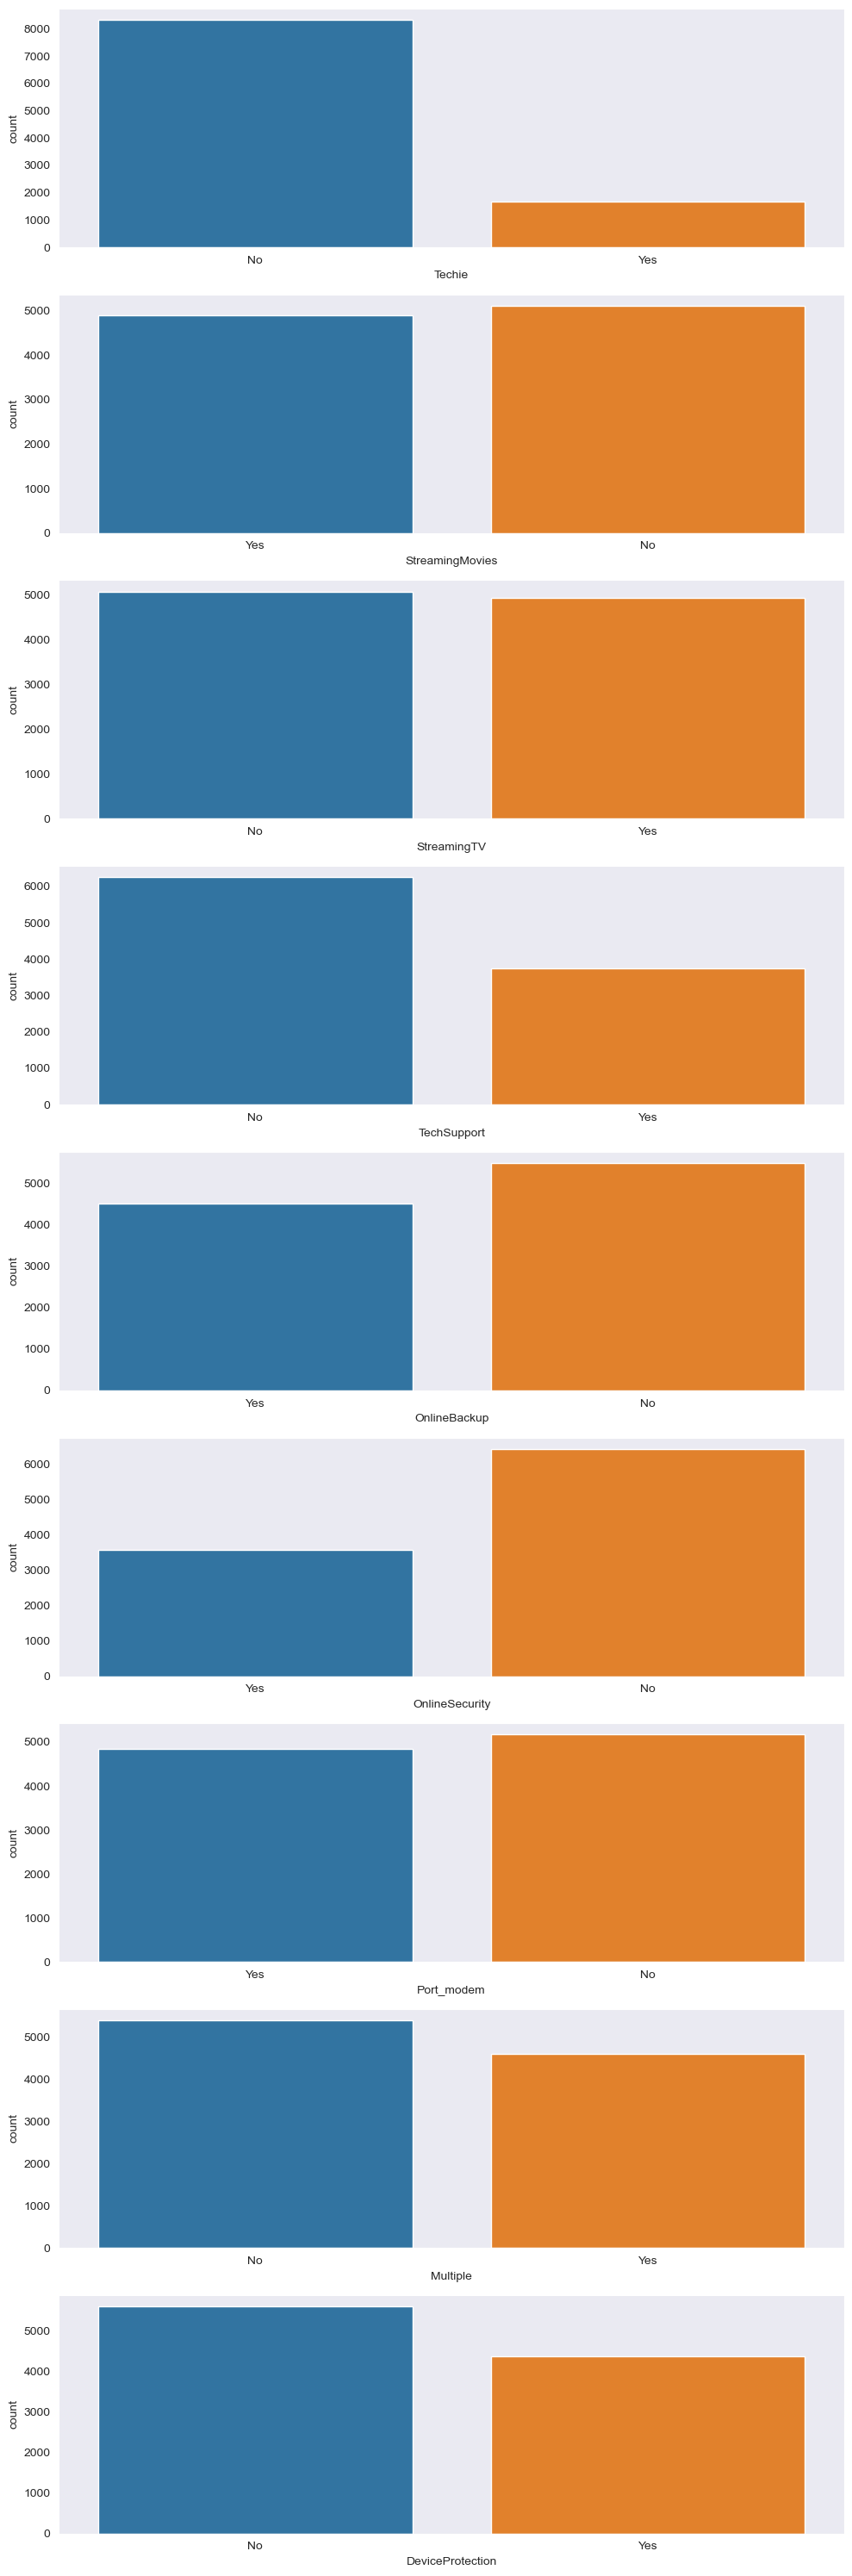

In [230]:
fig , ax = plt.subplots(9,figsize = (10,30))  
for i , subplots in zip (df_categorical, ax.flatten()):  
  sns.countplot(df_categorical[i],ax = subplots)
plt.tight_layout()
plt.show()

### Data Exploration - Bivariate

In [271]:
df.groupby(by='Churn').agg('mean')[['Children', 'Age', 'Income', 'Outage_sec_perweek','Email', 'Contacts', 'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year']]

,Children,Age,Income,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year
Churn,,,,,,,,,,
No,2.093197,53.008435,39706.395664,10.002128,11.993605,0.989116,0.404082,42.234090,163.008973,3971.855917
Yes,2.072453,53.272453,40085.758332,10.001073,12.078113,1.008302,0.381132,13.147667,199.295175,1785.009247


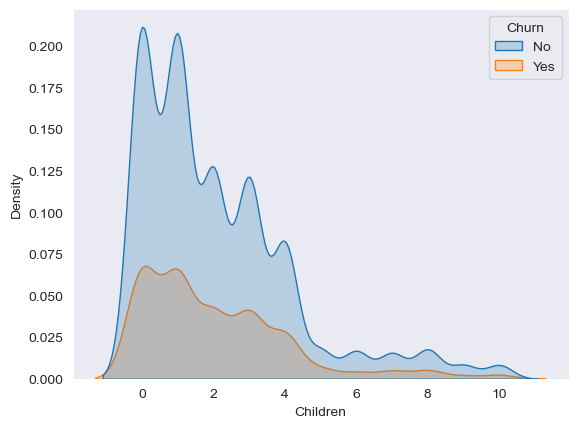

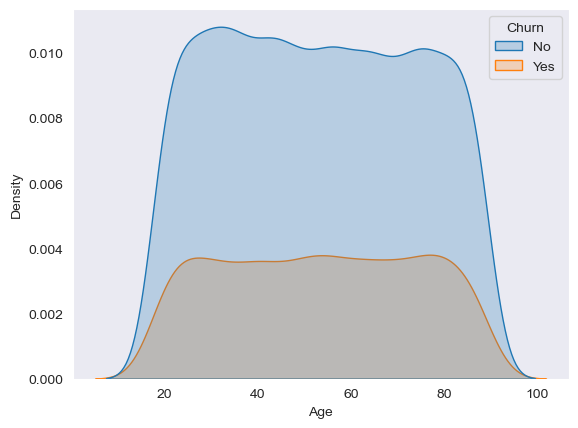

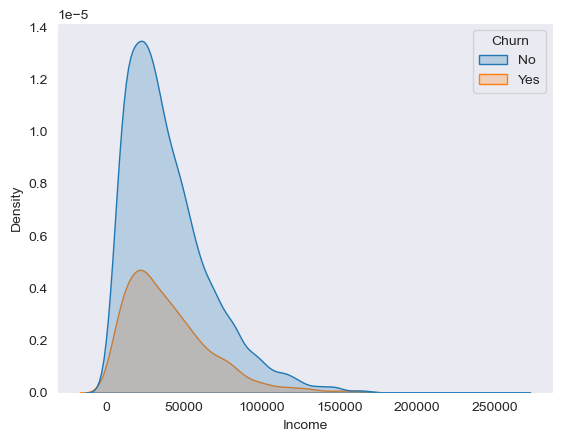

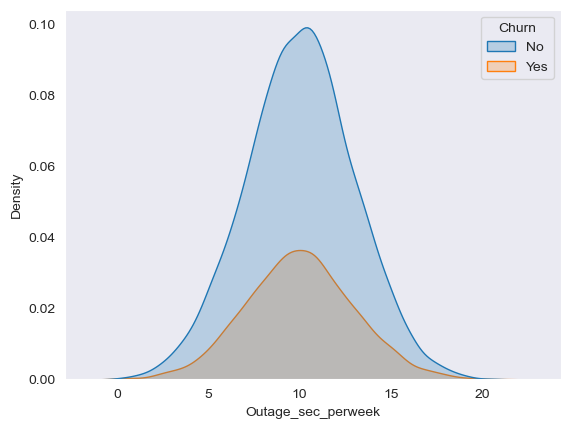

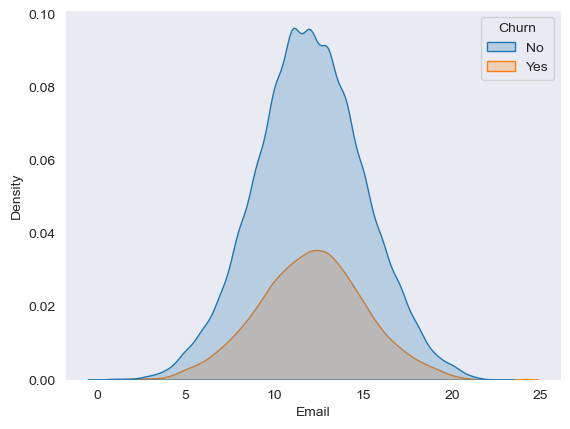

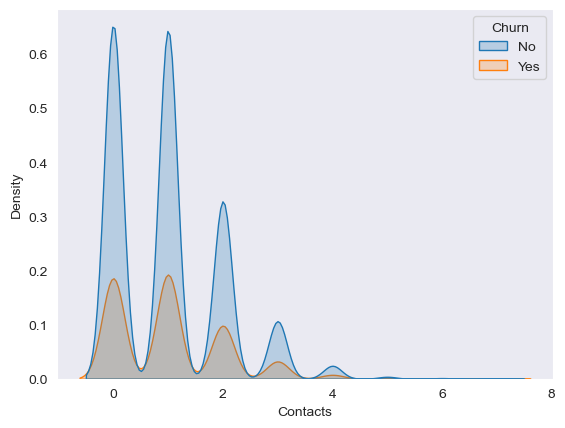

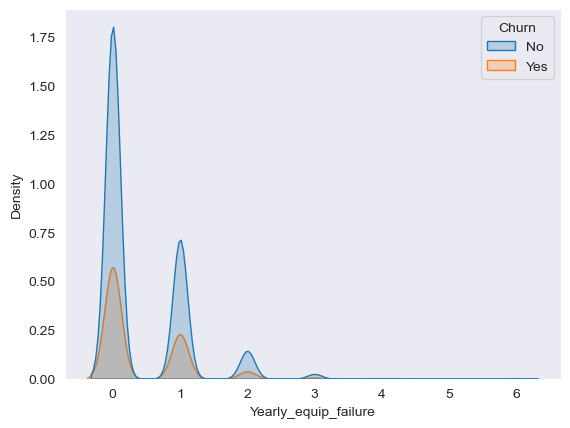

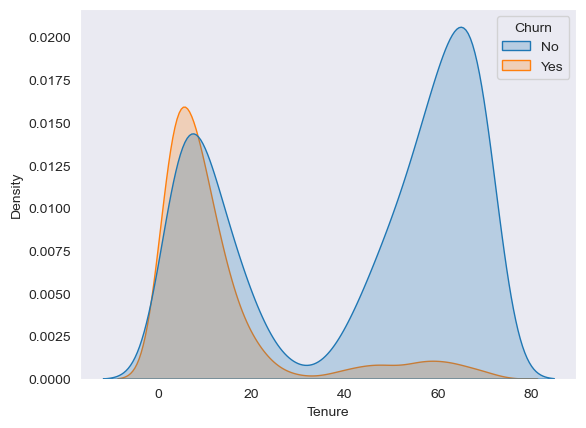

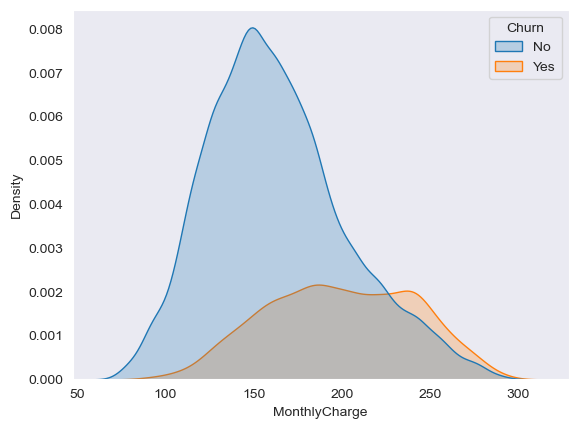

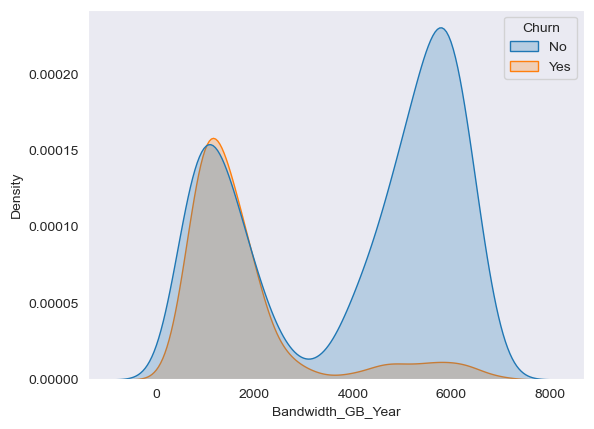

In [272]:
for i in CheckOutliers:
    sns.kdeplot(data=df, x=i, hue='Churn', fill=True)
    plt.show()

In [273]:
pd.crosstab([df.Techie, df.StreamingMovies, df.StreamingTV, df.TechSupport, df.OnlineBackup, df.OnlineSecurity, df.Port_modem, df.Multiple, df.DeviceProtection], df.Churn, margins=True)

Churn                                                                                                              No  \
Techie StreamingMovies StreamingTV TechSupport OnlineBackup OnlineSecurity Port_modem Multiple DeviceProtection         
No     No              No          No          No           No             No         No       No                  72   
                                                                                               Yes                 60   
                                                                                      Yes      No                  57   
                                                                                               Yes                 35   
                                                                           Yes        No       No                  80   
...                                                                                                               ...   
Yes    Yes             Yes         Yes         Yes          Yes            No         Yes      Yes                  0   
                                                                           Yes        No       Yes                  1   
                                                                                      Yes      No                   0   
                                                                                               Yes                  0   
All                                                                                                              7350   

Churn                                                                                                             Yes  \
Techie StreamingMovies StreamingTV TechSupport OnlineBackup OnlineSecurity Port_modem Multiple DeviceProtection         
No     No              No          No          No           No             No         No       No                   2   
                                                                                               Yes                  2   
                                                                                      Yes      No                   4   
                                                                                               Yes                  7   
                                                                           Yes        No       No                   1   
...                                                                                                               ...   
Yes    Yes             Yes         Yes         Yes          Yes            No         Yes      Yes                  1   
                                                                           Yes        No       Yes                  3   
                                                                                      Yes      No                   4   
                                                                                               Yes                  1   
All                                                                                                              2650   

Churn                                                                                                              All  
Techie StreamingMovies StreamingTV TechSupport OnlineBackup OnlineSecurity Port_modem Multiple DeviceProtection         
No     No              No          No          No           No             No         No       No                   74  
                                                                                               Yes                  62  
                                                                                      Yes      No                   61  
                                                                                               Yes                  42  
                                                                           Yes        No       No                   81  
...  

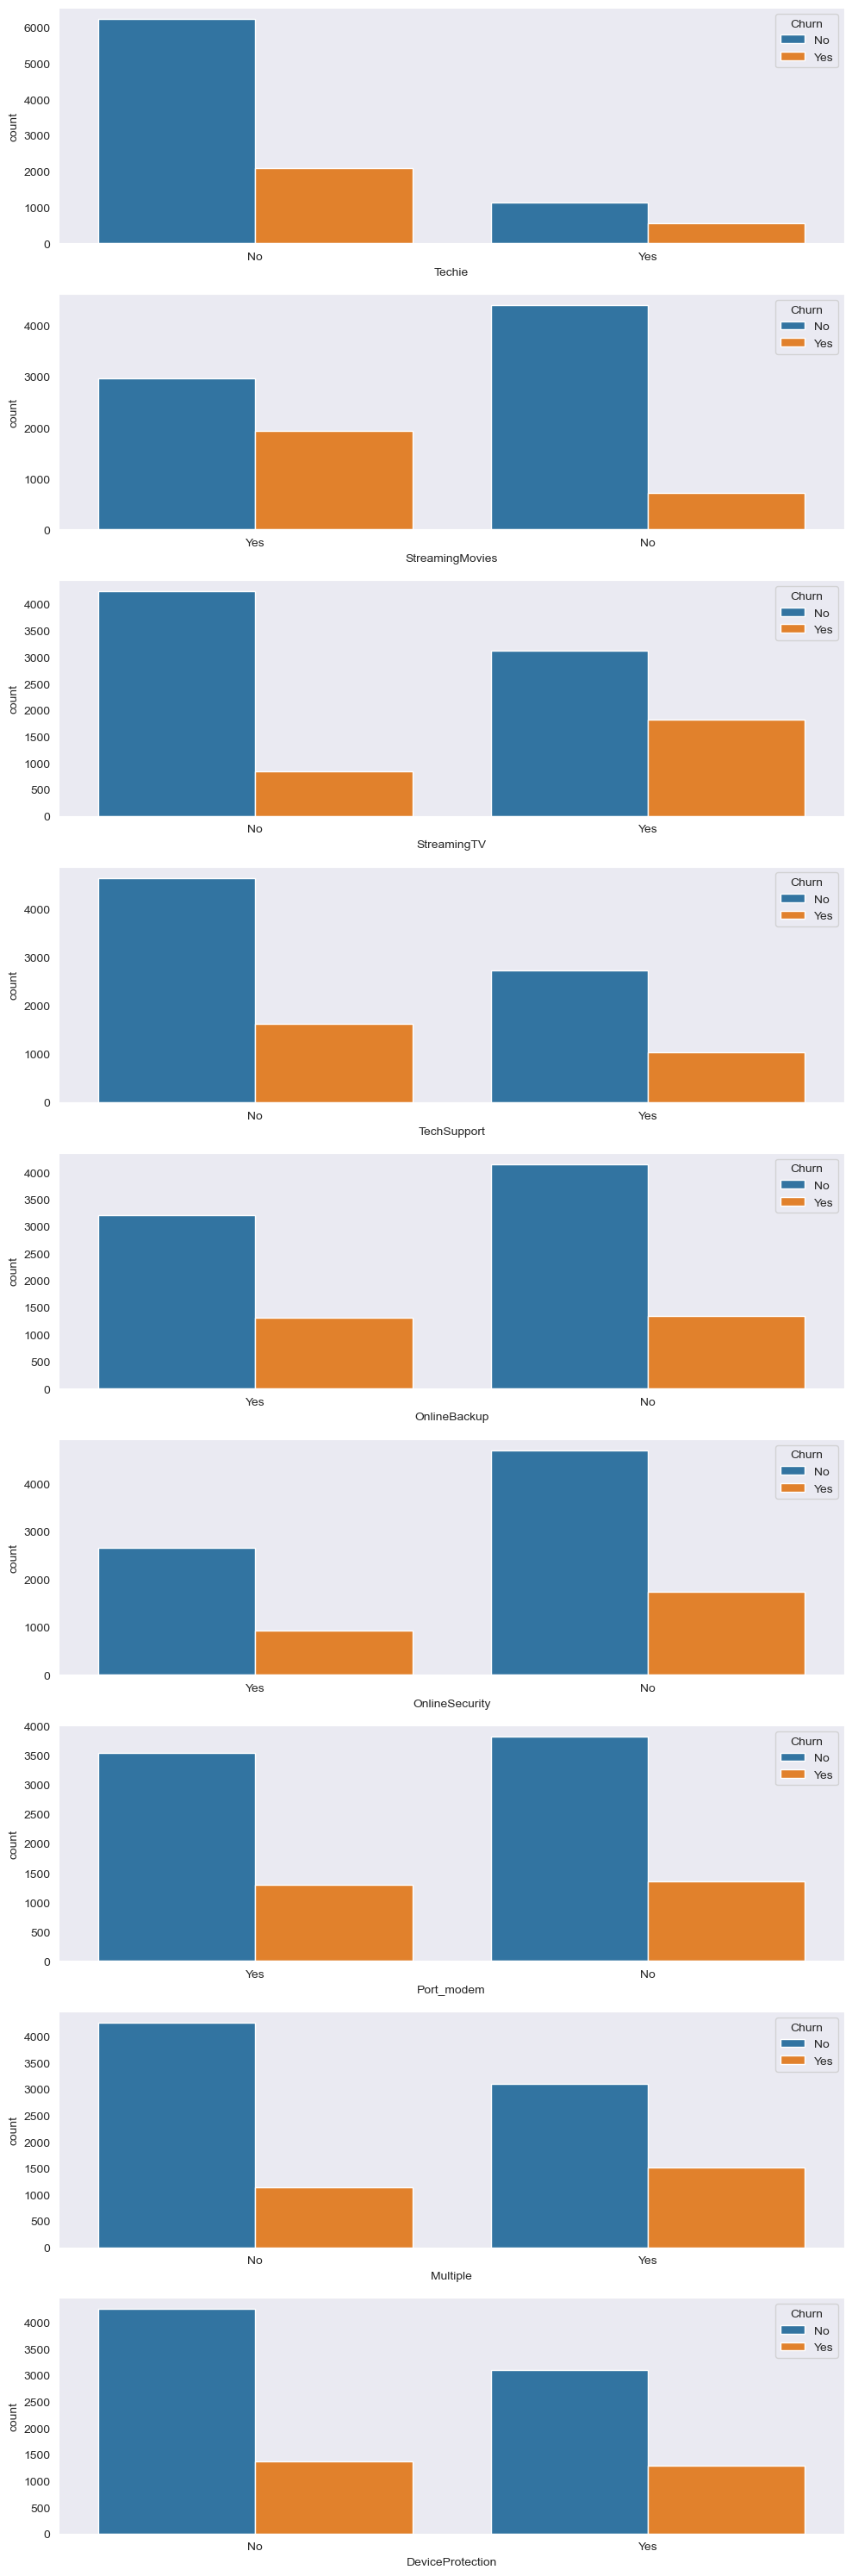

In [274]:
fig , ax = plt.subplots(9,figsize = (10,30))  
for i , subplots in zip (df_categorical, ax.flatten()):  
  sns.countplot(df_categorical[i], ax = subplots, hue= df['Churn'])
plt.tight_layout()
plt.show()

### Data Wrangling - Re-expression of Ordinal Categorial Variables

In [275]:
df[['Techie', 'Churn', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'OnlineBackup', 'OnlineSecurity', 'Port_modem', 'Multiple', 'DeviceProtection']].head(10)

,Techie,Churn,StreamingMovies,StreamingTV,TechSupport,OnlineBackup,OnlineSecurity,Port_modem,Multiple,DeviceProtection
0,No,No,Yes,No,No,Yes,Yes,Yes,No,No
1,Yes,Yes,Yes,Yes,No,No,Yes,No,Yes,No
2,Yes,No,Yes,No,No,No,No,Yes,Yes,No
3,Yes,No,No,Yes,No,No,Yes,No,No,No
4,No,Yes,No,Yes,Yes,No,No,Yes,No,No
5,No,No,Yes,No,No,Yes,Yes,Yes,Yes,Yes
6,Yes,Yes,Yes,Yes,Yes,No,No,No,No,No
7,Yes,Yes,No,No,No,Yes,No,No,No,No
8,No,No,No,No,No,Yes,Yes,Yes,No,No
9,No,No,Yes,No,No,No,Yes,Yes,No,Yes


In [276]:
for col in categorical:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes

In [277]:
df[['Techie', 'Churn', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'OnlineBackup', 'OnlineSecurity', 'Port_modem', 'Multiple', 'DeviceProtection']].head(10)

,Techie,Churn,StreamingMovies,StreamingTV,TechSupport,OnlineBackup,OnlineSecurity,Port_modem,Multiple,DeviceProtection
0,0,0,1,0,0,1,1,1,0,0
1,1,1,1,1,0,0,1,0,1,0
2,1,0,1,0,0,0,0,1,1,0
3,1,0,0,1,0,0,1,0,0,0
4,0,1,0,1,1,0,0,1,0,0
5,0,0,1,0,0,1,1,1,1,1
6,1,1,1,1,1,0,0,0,0,0
7,1,1,0,0,0,1,0,0,0,0
8,0,0,0,0,0,1,1,1,0,0
9,0,0,1,0,0,0,1,1,0,1


In [295]:
# Assign values to X for all predictor features
# Assign values to y for the dependent variable

x = df[['Children', 'Age', 'Income', 'Outage_sec_perweek','Email', 'Contacts', 'Yearly_equip_failure', 'MonthlyCharge', 'Bandwidth_GB_Year', 'Techie', 
        'Tenure', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'OnlineBackup', 'OnlineSecurity', 'Port_modem', 'Multiple', 'DeviceProtection']]
y = df[['Churn']]

In [296]:
# Feature Selection

feature_names = x.columns
skbest = SelectKBest(score_func = f_classif, k='all') # k=10
X_new = skbest.fit_transform(x, y)
X_new.shape	
p_values = pd.DataFrame({'Feature': x.columns, 'p_value':skbest.pvalues_}).sort_values('p_value')
p_values[p_values['p_value'] < .05]
features_to_keep = p_values['Feature'][p_values['p_value'] < .05]
features_to_keep

10               Tenure
8     Bandwidth_GB_Year
7         MonthlyCharge
11      StreamingMovies
12          StreamingTV
17             Multiple
9                Techie
18     DeviceProtection
14         OnlineBackup
Name: Feature, dtype: object

In [297]:
# Split the data into training and test data sets and provide the file(s)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

In [281]:
X_train.to_csv(r'C:\Users\Marusya\Desktop\X_train.csv')
X_test.to_csv(r'C:\Users\Marusya\Desktop\X_test.csv')
y_train.to_csv(r'C:\Users\Marusya\Desktop\y_train.csv')
y_test.to_csv(r'C:\Users\Marusya\Desktop\y_test.csv')

In [298]:
# Scale the features using StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Classification Analysis

In [301]:
# KNN Model with GridSearch result of k=16

knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=16)

In [302]:
# Model Evaluation Metrics

print("The score (accuracy) of the KNN model:", knn.score(X_test, y_test))
y_predicted = knn.predict(X_test)
print("The confusion matrix for the KNN model") 
print(confusion_matrix(y_test, y_predicted)) 
y_predicted_probability=knn.predict_proba (X_test) [:,1] 
print("The Area Under the Curve (AUC) for the KNN model:", roc_auc_score(y_test, y_predicted_probability)) 
print(classification_report(y_test,y_pred))

The score (accuracy) of the KNN model: 0.8335
The confusion matrix for the KNN model
[[1388   82]
 [ 251  279]]
The Area Under the Curve (AUC) for the KNN model: 0.8855352329611089
              precision    recall  f1-score   support

           0       0.73      0.78      0.76      1470
           1       0.24      0.19      0.21       530

    accuracy                           0.63      2000
   macro avg       0.48      0.49      0.48      2000
weighted avg       0.60      0.63      0.61      2000



In [285]:
# KNN Model with Hyperparameter Tuning

x = df[features_to_keep]
y = df[['Churn']] 

steps = [('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())]
pipeline = Pipeline(steps)

parameters = {'knn__n_neighbors': np.arange(1,25)} 
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size=0.2, random_state=15, stratify=y)

knncv = GridSearchCV(estimator = pipeline,
                    param_grid = parameters,
                    n_jobs=-1,
                    cv = 5)
knncv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [286]:
# More Evaluation Metrics

print("Best params:", knncv.best_params_)
print("Score", knncv.best_score_)
y_pred = knncv.predict(X_test)
print("Accuracy score for model: ",accuracy_score(y_test,y_pred))

Best params: {'knn__n_neighbors': 16}
Score 0.846125
Accuracy score for model:  0.8435


### Model Complexity Curve 

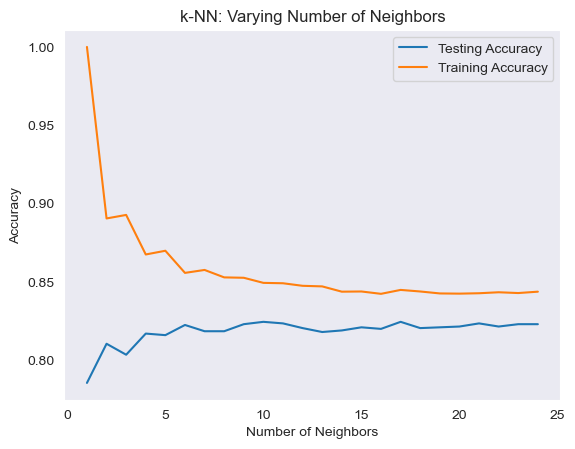

In [287]:
neighbors = np.arange(1, 25)
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate (neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score (X_test, y_test)

plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy') 
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Accuracy Score

In [288]:
print("The Training Accuracy is: ",knncv.score(X_train, y_train))

The Training Accuracy is:  0.860625


In [289]:
print("The Testing Accuracy is: ",knncv.score(X_test, y_test))

The Testing Accuracy is:  0.8435


In [290]:
# Scores of Accuracy
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1470
           1       0.76      0.60      0.67       530

    accuracy                           0.84      2000
   macro avg       0.81      0.77      0.78      2000
weighted avg       0.84      0.84      0.84      2000



In [291]:
# Plot of a ROC curve
fpr,tpr,_=roc_curve(y_test,y_pred)
roc_auc=auc(fpr,tpr)

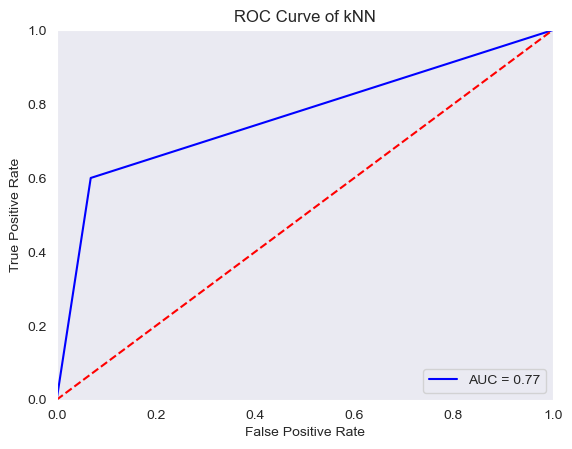

In [292]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

In [293]:
print("The area under the Receiver Operating Characteristic Curve is: ", roc_auc_score(y_test,y_pred))

The area under the Receiver Operating Characteristic Curve is:  0.7656462585034014


In [303]:
df.to_csv(r'C:\Users\Marusya\Desktop\Jose_Costa_Churn.csv')